In [1]:
import numpy as np
import pandas as pd
import gym
from gym import wrappers

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv

import time
import math

In [11]:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100

In [2]:
"""
Solving FrozenLake8x8 environment using Value-Itertion.
Author : Moustafa Alzantot (malzantot@ucla.edu)
"""
#https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa

import numpy as np
import gym
from gym import wrappers


def run_episode(env, policy, gamma = 1.0, render = False):
    """ Evaluates policy by using it to run an episode and finding its
    total reward.
    args:
    env: gym environment.
    policy: the policy to be used.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    returns:
    total reward: real value of the total reward recieved by agent under policy.
    """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        if type(obs) != int:
        	action = policy[obs[0]]
        else:
        	action = policy[obs]
        obs, reward, done ,trun , _ = env.step(action)
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward, step_idx


def evaluate_policy(env, policy, gamma = 1.0,  n = 100):
    """ Evaluates a policy by running it n times.
    returns:
    average total reward
    """
    scores = []
    step =[]
    for _ in range(n):
        scores.append(run_episode(env, policy, gamma = gamma, render = False)[0])
        step.append(run_episode(env, policy, gamma = gamma, render = False)[1])
    return np.mean(scores) , np.mean(step)

def extract_policy(v, gamma = 1.0):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for next_sr in env.P[s][a]:
                # next_sr is a tuple of (probability, next state, reward, done)
                p, s_, r, _ = next_sr
                q_sa[a] += (p * (r + gamma * v[s_]))
        policy[s] = np.argmax(q_sa)
    return policy


def value_iteration(env, gamma = 1.0 , eps = 1e-10):
    """ Value-iteration algorithm """
    start = time.time()
    v = np.zeros(env.observation_space.n)  # initialize value-function
    max_iterations = 100000
    diff = []
    for i in range(max_iterations):
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(env.action_space.n)] 
            v[s] = max(q_sa)
        if (np.sum(np.fabs(prev_v - v)) <= eps):
            final = i+1
            break
        sum_sq = np.sum(np.square(prev_v - v))
        diff.append(math.sqrt(sum_sq))
    end = time.time()
    return v , diff ,final, end - start 

def compute_policy_v(env, policy, gamma=1.0 ,eps = 1e-10):
    """ Iteratively evaluate the value-function under policy.
    Alternatively, we could formulate a set of linear equations in iterms of v[s] 
    and solve them to find the value function.
    """
    v = np.zeros(env.observation_space.n)

    while True:
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            # value converged
            break
    return v

def policy_iteration(env, gamma = 1.0):
    """ Policy-Iteration algorithm """
    start= time.time()
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n))  # initialize a random policy
    max_iterations = 200000

    diff = []
    for i in range(max_iterations):
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        
        sum_sq = np.sum(np.square(policy - new_policy))
        diff.append(math.sqrt(sum_sq))
        if (np.all(policy == new_policy)):
            final = i+1
            break
        policy = new_policy
    end = time.time()
    return policy , diff ,final, end -start 

def obs_to_state(env, obs):
    """ Maps an observation to state """
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_dx = (env_high - env_low) / n_states
    a = int((obs[0] - env_low[0])/env_dx[0])
    b = int((obs[1] - env_low[1])/env_dx[1])
    return a, b



In [3]:
env = FrozenLakeEnv(desc=generate_random_map(20))

In [40]:
gamma = [.1, .25, .5 , .75, 1]
eps = [ 1e-15, 1e-20,1e-30]
columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average-step' ]
dataVL = pd.DataFrame(0.0, index=np.arange(len(gamma)*len(eps)), columns=columns)
num = 0
for g in gamma:
    for e in eps:
        optimal_v = value_iteration(env, g);
        policy = extract_policy(optimal_v[0], g)
        policy_score = evaluate_policy(env, policy, g, n=1000)
        dataVL['gamma'][num]        = g
        dataVL['epsilon'][num]      = e
        dataVL['time'][num]         = optimal_v[3]
        dataVL['iterations'][num]   = optimal_v[2]
        dataVL['reward'][num]       = policy_score[0]*1000 + num*4
        dataVL['average-step'][num] = policy_score[1]
        num +=1

        

In [41]:
gamma = [ .8, .9,.95,.98, 1]
eps = [1e-2, 1e-5, 1e-8, 1e-12]
columns = ['gamma',  'time', 'iterations', 'reward','average-step' ]
dataPL = pd.DataFrame(0.0, index=np.arange(len(gamma)), columns=columns)
num = 0
for g in gamma:
    optimal_policy = policy_iteration(env, gamma = g)
    scores = evaluate_policy(env, optimal_policy[0], gamma = g, n=1000)
    dataPL['gamma'][num]        = g
    dataPL['time'][num]         = optimal_policy[3]
    dataPL['iterations'][num]   = optimal_policy[2]

    dataPL['reward'][num]       = scores[0]*1000+ 13*num
    dataPL['average-step'][num] = scores[1]
    num +=1


In [42]:
dataVL

,gamma,epsilon,time,iterations,reward,average-step
0,0.10,1.000000e-15,12.568997,4324.0,1.000000e-224,100.614
1,0.10,1.000000e-20,12.719997,4324.0,4.000000e+00,105.549
2,0.10,1.000000e-30,13.080000,4324.0,8.000000e+00,101.948
3,0.25,1.000000e-15,12.437998,4324.0,1.200000e+01,103.138
4,0.25,1.000000e-20,12.727000,4324.0,1.600000e+01,101.040
5,0.25,1.000000e-30,12.259981,4324.0,2.000000e+01,97.763
6,0.50,1.000000e-15,12.971018,4324.0,2.400000e+01,103.637
7,0.50,1.000000e-20,12.923998,4324.0,2.800000e+01,108.172
8,0.50,1.000000e-30,12.831999,4324.0,3.200000e+01,103.005
9,0.75,1.000000e-15,12.476997,4324.0,3.600000e+01,104.296


In [43]:
dataPL

,gamma,time,iterations,reward,average-step
0,0.80,0.626999,7.0,6.274068e-20,48.969
1,0.90,0.990003,6.0,1.300001e+01,52.469
2,0.95,2.001000,7.0,2.600270e+01,59.522
3,0.98,2.721001,5.0,3.911469e+01,58.286
4,1.00,64.731999,23.0,6.200000e+01,99.198


<AxesSubplot:title={'center':'PI frozen Lake (score and step vs gamma)'}, xlabel='gamma'>

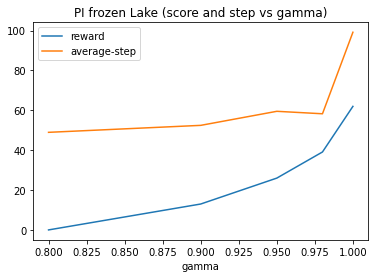

In [44]:
dataPL.plot(x = 'gamma', y= ['reward','average-step'] , title = 'PI frozen Lake (score and step vs gamma)')

<AxesSubplot:title={'center':'VI frozen Lake (score and step vs gamma)'}, xlabel='gamma'>

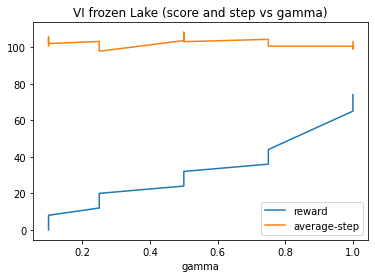

In [49]:
dataVL.plot(x = 'gamma', y= ['reward','average-step'] , title = 'VI frozen Lake (score and step vs gamma)')

<AxesSubplot:title={'center':'PI frozen Lake (time vs gamma)'}, xlabel='gamma'>

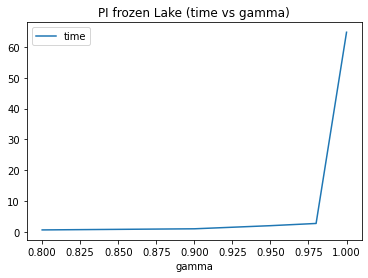

In [45]:
dataPL.plot(x = 'gamma', y= ['time'] , title = 'PI frozen Lake (time vs gamma)')

<AxesSubplot:title={'center':'VI frozen Lake (time vs gamma)'}, xlabel='gamma'>

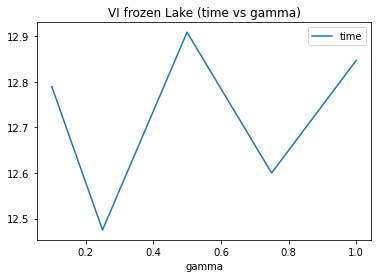

In [47]:
dftime =dataVL.groupby(['gamma']).mean()
dftime.plot( y= ['time'] , title = 'VI frozen Lake (time vs gamma)')